<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Carteiras-Investimentos-Com-Rebalanceamentos/blob/rebalanceamento_01/Otimiza%C3%A7%C3%A3o_de_Carteiras_de_Investimentos_com_Rebalanceamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aplica√ß√£o de Modelos de Confiabilidade e Metaheur√≠sticas na Otimiza√ß√£o de Carteiras de Investimentos com Rebalanceamentos relacionados ao risco**


**Objetivo**

O objetivo do trabalho √© desenvolver e validar uma metodologia para a otimiza√ß√£o de carteiras de investimento, com foco na identifica√ß√£o da necessidade e nos valores √≥timos dos rebalanceamentos dos ativos. A proposta envolve a modelagem da ocorr√™ncia de eventos de mercado que possam impactar significativamente os pre√ßos dos ativos, bem como notas de ag√™ncia de avalia√ß√£o. O estudo ser√° realizado utilizando Modelos de Sobreviv√™ncia baseados na Distribui√ß√£o de Weibull com Frailty, a fim de capturar riscos externos n√£o observ√°veis, como not√≠cias inesperadas e decis√µes governamentais. Os dados ser√£o extra√≠dos em 3 arquivos csv diferentes, o primeiro direto de uma base da B3, que ser√° o relat√≥rio consolidado da carteira de investimentos. O segundo ser√° extra√≠do da api da Brapi com os dados dos ativos. E o terceiro de alguma ag√™ncia de avalia√ß√£o (ainda em avalia√ß√£o).
Os par√¢metros dos modelos ser√£o estimados utilizando a fun√ß√£o de M√°xima Verossimilhan√ßa, garantindo o ajuste adequado aos dados hist√≥ricos das s√©ries de pre√ßos dos ativos. A partir da modelagem dos eventos, pretende-se determinar, por meio de Otimiza√ß√£o Bayesiana, os pontos √≥timos de rebalanceamento dos ativos da carteira, considerando informa√ß√µes como pre√ßo atual, pre√ßo m√©dio, n√∫mero de a√ß√µes, valor total investido em cada ativo e valor total investido na carteira. Os dados ser√£o extra√≠dos em um 3 arquivo csv direto de uma base da B3.
Al√©m disso, ser√° realizada a otimiza√ß√£o multiobjetiva da carteira empregando os algoritmos NSGA-II (Non-dominated Sorting Genetic Algorithm II) e MOPSO (Multi-Objective Particle Swarm Optimization), visando simultaneamente:
‚Ä¢	Maximizar o retorno esperado,
‚Ä¢	Minimizar o risco da carteira,
‚Ä¢	Minimizar os custos associados aos rebalanceamentos.
Por fim, ser√° conduzida uma an√°lise comparativa entre as abordagens propostas, com a avalia√ß√£o de m√©tricas de qualidade de solu√ß√µes multiobjetivas (como hipervolume, spread e IGD) e compara√ß√£o com estrat√©gias tradicionais de rebalanceamento peri√≥dico, buscando evidenciar as vantagens e limita√ß√µes da metodologia em cen√°rios pr√°ticos.

**Objetivo Espec√≠fico**

1.	Modelar a ocorr√™ncia de eventos de mercado que possam afetar significativamente os pre√ßos dos ativos, utilizando Modelos de Sobreviv√™ncia baseados na Distribui√ß√£o de Weibull com Frailty para capturar riscos n√£o observ√°veis.

2.	Utilizar Otimiza√ß√£o Bayesiana por meio da biblioteca Optuna para determinar os pesos √≥timos dos ativos na carteira, considerando o retorno esperado, risco e custos de rebalanceamento.

3.	Implementar a otimiza√ß√£o multiobjetiva da carteira utilizando os algoritmos NSGA-II (Non-dominated Sorting Genetic Algorithm II) e MOPSO (Multi-Objective Particle Swarm Optimization) para maximizar o retorno esperado, minimizar o risco da carteira e os custos associados aos rebalanceamentos.


4.	Realizar uma an√°lise comparativa entre as abordagens propostas (Otimiza√ß√£o Bayesiana com Optuna, NSGA-II e MOPSO), avaliando as solu√ß√µes geradas atrav√©s de m√©tricas de qualidade multiobjetiva, como hipervolume, spread e IGD, e comparando com estrat√©gias tradicionais de rebalanceamento peri√≥dico.


In [2]:
# **Instala√ß√£o de Bibliotecas e Importa√ß√£o de Depend√™ncias**
%%capture
!pip install lifelines -U pymoo seaborn optuna pytesseract opencv-python

In [3]:
# Bibliotecas essenciais para manipula√ß√£o de dados e otimiza√ß√£o
import numpy as np
import pandas as pd
import optuna
import requests
import seaborn as sns
import cv2
import pytesseract
import re
import lifelines
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Bibliotecas de an√°lise de sobreviv√™ncia
from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter

# Bibliotecas de otimiza√ß√£o multiobjetivo
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.termination import get_termination
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import Problem
from pymoo.indicators.hv import HV
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Suporte para exibir imagens no Colab
from google.colab.patches import cv2_imshow

# Ferramentas adicionais
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Token para acesso √† API da Brapi (https://brapi.dev/)
token = 'wQsv3whghhynsSiXQj18Jm'

# Intervalo de tempo para consulta dos dados hist√≥ricos
interval = '3mo'

# Valor de aporte para simula√ß√µes e otimiza√ß√£o
VALOR_APORTE = 5000.00  # Exemplo: R$ 5.000,00 de aporte inicial

Nesse ponto foi criado um arquivo com dados simulados. Porem, esses dados podem ser extraido da B3.

Para realizar a simula√ß√£o foi utilizado o codigo: https://github.com/uervitonsantos/simula-dados-carteira-investimentos/blob/main/Simula_dados_de_opera%C3%A7%C3%B5es_em_cateira_de_investimento.ipynb

Link para acesso ao Dataset: https://drive.google.com/file/d/1-15NzorUCz7iS8TuuATr6ADaOYdbOlOF/view?usp=drive_link

In [6]:
# Leitura dos dados da carteira inicial contendo os ativos a serem analisados
df = pd.read_csv('/content/drive/MyDrive/datasets/dados-acoes/carteira-de-ativos.csv', sep=",")

# Visualiza√ß√£o dos primeiros registros do dataset
df.head(3)

Entrada/Sa√≠da        Data            Produto  Quantidade Pre√ßo unit√°rio  \
0        Compra  15/03/2021  VALE3 - VALE S.A.           8       R$ 73,02   
1        Compra  14/04/2021  VALE3 - VALE S.A.          62       R$ 54,78   
2        Compra  14/05/2021  VALE3 - VALE S.A.           4       R$ 69,01   

  Valor da Opera√ß√£o  
0         R$ 584,16  
1       R$ 3.396,36  
2         R$ 276,04

# **Pr√©-processamento e Organiza√ß√£o dos Dados Operacionais**

Nesta etapa, foi realizado o pr√©-processamento dos dados provenientes de opera√ß√µes financeiras, com o objetivo de estrutur√°-los adequadamente para an√°lise. Inicialmente, a coluna correspondente √†s datas das opera√ß√µes foi convertida para o tipo datetime, utilizando o par√¢metro dayfirst=True para considerar o formato de data com o dia precedendo o m√™s, padr√£o comum no Brasil. Em seguida, realizou-se a padroniza√ß√£o da coluna referente aos produtos negociados, por meio da aplica√ß√£o de uma express√£o regular que extrai exclusivamente o c√≥digo do ativo (ticker), tipicamente formado por quatro letras seguidas de um n√∫mero, como PETR4 ou VALE3.

A partir desses c√≥digos, foi criada uma nova coluna chamada "Ticker", que isola o identificador do ativo, removendo poss√≠veis descri√ß√µes adicionais que pudessem estar presentes. Para caracterizar o tipo de opera√ß√£o, a coluna "Entrada/Sa√≠da" foi mapeada para valores num√©ricos, atribuindo 1 √†s opera√ß√µes de compra (indicando entrada do ativo na carteira) e 0 √†s de venda (representando a sa√≠da do ativo).

Com o intuito de calcular o tempo decorrido desde cada opera√ß√£o at√© a data de refer√™ncia da an√°lise, foi criada a vari√°vel "Tempo", obtida pela diferen√ßa entre a data atual do sistema e a data da opera√ß√£o. Para evitar valores nulos ou negativos, somou-se uma unidade ao resultado e aplicou-se um limite inferior m√≠nimo de 0.1, garantindo valores positivos em formato de ponto flutuante.

Adicionalmente, os valores monet√°rios presentes nas colunas "Valor da Opera√ß√£o" e "Pre√ßo unit√°rio" foram tratados para remover formata√ß√µes espec√≠ficas do sistema financeiro brasileiro, como o s√≠mbolo de real (R$), os separadores de milhar (.) e a v√≠rgula decimal (,) que foram convertidos para o padr√£o num√©rico utilizado no ambiente de programa√ß√£o. Ap√≥s essas transforma√ß√µes, os campos foram convertidos para o tipo float.

Por fim, com vistas √† obten√ß√£o de uma s√©rie hist√≥rica representativa, os dados foram agrupados por data e ticker, e o pre√ßo m√©dio unit√°rio foi calculado para cada ativo em cada data, utilizando a fun√ß√£o de m√©dia (mean). Esse agrupamento foi reestruturado com a fun√ß√£o unstack, resultando em uma tabela bidimensional onde as colunas representam os diferentes ativos e as linhas representam as datas, com os respectivos pre√ßos m√©dios hist√≥ricos.

In [7]:
# Garante que a coluna 'Data' est√° no formato datetime
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True, errors='coerce')

# Extra√ß√£o do ticker dos ativos a partir da coluna 'Produto'
# Exemplo de 'Produto': 'CSAN3 - COSAN'
df['Ticker'] = df['Produto'].str.extract(r'([A-Z]{4,5}\d{1,2})')

# Cria uma coluna 'Ticker' apenas com o c√≥digo do ativo antes de qualquer descri√ß√£o
df['Ticker'] = df['Produto'].str.split(' - ').str[0].str.strip()

# Mapeamento do tipo de opera√ß√£o para evento bin√°rio:
# Compra = 1 (ativo entra na carteira)
# Venda = 0 (ativo sai da carteira)
df['Evento'] = df['Entrada/Sa√≠da'].map({'Compra': 1, 'Venda': 0})

# C√°lculo do tempo (em dias) desde a data da opera√ß√£o at√© a data atual
data_referencia = pd.to_datetime(datetime.today().date())  # Data atual
df['Tempo'] = (data_referencia - df['Data']).dt.days + 1  # Adiciona +1 para evitar zero
df['Tempo'] = df['Tempo'].clip(lower=0.1).astype(float)   # Garante que seja positivo e float

# Limpeza dos valores monet√°rios nas colunas de opera√ß√£o e pre√ßo unit√°rio
# Remove 'R$', pontos e substitui v√≠rgula por ponto
df['Valor da Opera√ß√£o'] = (df['Valor da Opera√ß√£o'].replace({'R\$': '', '\.': '', ',': '.'}, regex=True).astype(float))
df['Pre√ßo unit√°rio'] = (df['Pre√ßo unit√°rio'].replace({'R\$': '', '\.': '', ',': '.'}, regex=True).astype(float))

# Agrupa por data e ticker, calculando o pre√ßo m√©dio do ativo na data
precos_historicos = (df.groupby(['Data', 'Ticker'])['Pre√ßo unit√°rio'].mean().unstack())  # Cria uma tabela onde cada coluna √© um ticker

# **C√°lculo do Tempo Mediano de Perman√™ncia dos Ativos na Carteira**

Com o objetivo de analisar a din√¢mica de perman√™ncia dos ativos na carteira ao longo do tempo, foi desenvolvido um procedimento para estimar, por ativo (ticker), o tempo mediano entre a data de compra e a data correspondente de venda. Inicialmente, os dados foram agrupados pela vari√°vel "Ticker", de modo que cada grupo representasse o hist√≥rico completo de opera√ß√µes de um determinado ativo.

Para cada ativo, foram separadas as listas de datas de compra (opera√ß√µes marcadas com valor 1 na coluna "Evento") e de venda (opera√ß√µes com valor 0). As listas foram ordenadas cronologicamente para garantir que os emparelhamentos fossem realizados na ordem temporal correta. Em seguida, utilizou-se a fun√ß√£o zip para emparelhar cada data de compra com a correspondente data de venda subsequente, assumindo que as opera√ß√µes seguem uma l√≥gica FIFO (First-In, First-Out). Apenas pares com venda posterior √† compra foram considerados v√°lidos para o c√°lculo.

Para cada par v√°lido (compra, venda), foi calculado o n√∫mero de dias decorridos entre as duas datas. A partir da lista de intervalos obtida para cada ativo, foi ent√£o calculada a mediana do tempo de perman√™ncia, de forma a obter uma medida robusta em rela√ß√£o a valores extremos ou outliers. Essa informa√ß√£o foi armazenada em um dicion√°rio, onde as chaves representam os tickers e os valores correspondem ao tempo mediano de perman√™ncia, em dias.

O resultado final constitui uma estrutura de dados que associa, de maneira eficiente, cada ativo ao seu tempo t√≠pico de reten√ß√£o na carteira, podendo ser utilizada posteriormente em an√°lises de perfil de negocia√ß√£o, constru√ß√£o de estrat√©gias ou avalia√ß√£o de liquidez.

In [8]:
# Calcula o tempo (em dias) desde a primeira compra at√© hoje, para cada ticker

data_atual = pd.to_datetime(datetime.today().date())

tempos_por_ticker = (
    df[df['Evento'] == 1]  # Apenas eventos de compra
    .groupby('Ticker')['Data']
    .min()  # Primeira compra
    .apply(lambda d: (data_atual - d).days + 1)  # Tempo em dias
    .to_dict()
)

# Resultado: dicion√°rio {ticker: dias_desde_primeira_compra}

In [9]:
# Seleciona as colunas necess√°rias para an√°lise de sobreviv√™ncia
df_surv = df[['Ticker', 'Tempo', 'Evento']]

# Lista de todos os tickers √∫nicos na base de dados
tickers = df['Ticker'].unique()

Para compor uma an√°lise fundamentalista e t√©cnica dos ativos listados em carteira, foi implementado um procedimento automatizado de extra√ß√£o de dados financeiros e de mercado por meio da API p√∫blica Brapi.dev: https://brapi.dev/. A etapa em quest√£o tem como finalidade consultar, para cada ticker (ativo), um conjunto de informa√ß√µes relevantes ao investimento, incluindo pre√ßo atual, indicadores fundamentais e varia√ß√µes recentes.

Inicialmente, foi criada uma lista vazia denominada dados_ativos, destinada a armazenar os resultados das consultas realizadas. Em seguida, um la√ßo de repeti√ß√£o (for) percorre a lista de tickers previamente definida, e, para cada ativo, √© constru√≠da uma URL personalizada contendo par√¢metros como intervalo de tempo (range), frequ√™ncia das cota√ß√µes (interval=1d), e os m√≥dulos desejados, como summaryProfile e fundamental.

A URL √© ent√£o requisitada via m√©todo GET utilizando a biblioteca requests. Caso a resposta da API apresente status de sucesso (200), os dados retornados s√£o processados no formato JSON. Dentre as informa√ß√µes extra√≠das, est√° o pre√ßo atual de mercado (regularMarketPrice) e o hist√≥rico di√°rio de pre√ßos de fechamento, contido no campo historicalDataPrice. A partir desses pre√ßos de fechamento, calcula-se a m√©dia do per√≠odo e, em seguida, a varia√ß√£o percentual entre o pre√ßo atual e essa m√©dia, servindo como um indicador t√©cnico de desvio.

Al√©m disso, o c√≥digo acessa dados fundamentais como o setor da empresa, o pre√ßo m√≠nimo e m√°ximo nas √∫ltimas 52 semanas, o √≠ndice Pre√ßo/Lucro (P/L), o Dividend Yield (DY), o Return on Equity (ROE), o Pre√ßo sobre Valor Patrimonial (P/VP) e o volume m√©dio de negocia√ß√£o dos √∫ltimos tr√™s meses. Todos esses dados s√£o armazenados como dicion√°rios dentro da lista dados_ativos, permitindo posterior an√°lise, visualiza√ß√£o ou persist√™ncia em banco de dados.

Caso a requisi√ß√£o para algum ticker falhe, o sistema emite um alerta na sa√≠da padr√£o, indicando o c√≥digo de erro HTTP correspondente. Esse tratamento garante maior robustez ao processo de coleta autom√°tica. Em conjunto, essa etapa fornece uma base s√≥lida para an√°lises quantitativas e qualitativas de cada ativo em carteira.

In [10]:
# Lista para armazenar os dados extra√≠dos de cada ativo
dados_ativos = []

# Loop para consultar cada ticker da carteira
for ticker in tickers:
    try:
        # Monta a URL de requisi√ß√£o para a API brapi.dev
        url = (
            f'https://brapi.dev/api/quote/{ticker}'
            f'?range={interval}&interval=1d&fundamental=true'
            f'&modules=summaryProfile&token={token}'
        )

        # Faz a requisi√ß√£o HTTP
        response = requests.get(url)

        # Verifica se a resposta foi bem-sucedida (status 200)
        if response.status_code == 200:
            data = response.json()
            print(f"{ticker}: OK")  # Log de sucesso na consulta

            # Extrai o primeiro resultado da resposta
            result = data.get('results', [{}])[0]

            # Pre√ßo atual do ativo
            preco_atual = result.get('regularMarketPrice')

            # Processa hist√≥rico de pre√ßos para calcular a m√©dia dos √∫ltimos dias
            historico = result.get('historicalDataPrice', [])
            precos_fechamento = [
                dia.get('close') for dia in historico if dia.get('close') is not None
            ]

            # Calcula a m√©dia dos pre√ßos de fechamento e a varia√ß√£o percentual
            if precos_fechamento:
                media_dias = sum(precos_fechamento) / len(precos_fechamento)
                variacao_pct = (
                    (preco_atual - media_dias) / media_dias if preco_atual else None
                )
            else:
                media_dias = None
                variacao_pct = None

            # Armazena os dados coletados em um dicion√°rio
            dados_ativos.append({
                'Ticker': ticker,
                'Empresa': result.get('shortName'),
                'Setor': result.get('summaryProfile', {}).get('sector'),
                'Pre√ßo Atual': preco_atual,
                'M√©dia em Dias': media_dias,
                'Varia√ß√£o % M√©dia em Dias': variacao_pct,
                'Min 52 Semanas': result.get('fiftyTwoWeekLow'),
                'Max 52 Semanas': result.get('fiftyTwoWeekHigh')
            })

        else:
            # Log de erro na requisi√ß√£o
            print(f"{ticker}: ERRO - {response.status_code}")

    except Exception as e:
        # Captura qualquer erro na execu√ß√£o da requisi√ß√£o ou processamento
        print(f"{ticker}: ERRO na requisi√ß√£o - {e}")

VALE3: OK
ITUB4: OK
PETR4: OK
WEGE3: OK
ABEV3: OK


In [11]:
# Converter os dados coletados em um DataFrame do Pandas
df_api = pd.DataFrame(dados_ativos)

# Salvar os dados em arquivo CSV no Google Drive
df_api.to_csv('/content/drive/MyDrive/datasets/dados-acoes/ativos_brapi.csv', index=False)

print("\n‚úÖ Dados salvos com sucesso em 'ativos_brapi.csv'.")


‚úÖ Dados salvos com sucesso em 'ativos_brapi.csv'.


In [12]:
# Carregar os dados dos ativos salvos anteriormente no CSV
df_api = pd.read_csv('/content/drive/MyDrive/datasets/dados-acoes/ativos_brapi.csv')

# Visualizar as 10 primeiras linhas do DataFrame
df_api.head(10)

Ticker                 Empresa               Setor  Pre√ßo Atual  \
0  VALE3  VALE        ON      NM     Basic Materials        53.00   
1  ITUB4  ITAUUNIBANCOPN  EJ  N1  Financial Services        36.27   
2  PETR4  PETROBRAS   PN      N2              Energy        31.21   
3  WEGE3  WEG         ON  ATZ NM         Industrials        42.35   
4  ABEV3          AMBEV S/A   ON  Consumer Defensive        13.15   

   M√©dia em Dias  Varia√ß√£o % M√©dia em Dias  Min 52 Semanas  Max 52 Semanas  
0      53.355738                 -0.006667          48.770           65.35  
1      35.420328                  0.023988          27.109           38.62  
2      31.658033                 -0.014152          28.860           40.76  
3      43.990820                 -0.037299          40.850           59.83  
4      13.917869                 -0.055171          10.720           15.03

Este script Python realiza uma an√°lise fundamentalista de a√ß√µes da B3 utilizando os dados do site Fundamentus. O objetivo √© pontuar e ranquear a√ß√µes com base em crit√©rios quantitativos de qualidade e valuation.


In [13]:
# Carregar os dados fundamentalistas dos ativos
df_fund = pd.read_csv('/content/drive/MyDrive/datasets/dados-acoes/pontuacao-dados-fundamentalistas.csv', sep=";")

# Visualizar as 10 primeiras linhas do DataFrame
df_fund.head(10)

A√ß√£o  Pontua√ß√£o
0  PETR4      83.33
1  VALE3      83.33
2  ABEV3      75.00
3  ITUB4      66.67
4  WEGE3      33.33

# **C√°lculo do Fator de Frailty com Base na Varia√ß√£o Percentual e Pontua√ß√£o Fundamentalista**

Com o intuito de incorporar um elemento de heterogeneidade no modelo de sobreviv√™ncia aplicado aos ativos financeiros, foi desenvolvido um procedimento para estimar o chamado fator de frailty (fragilidade) a partir da varia√ß√£o percentual entre o pre√ßo atual e a m√©dia dos pre√ßos de fechamento ao longo de um determinado intervalo de tempo. A no√ß√£o de frailty √© frequentemente utilizada em modelos de an√°lise de sobreviv√™ncia para representar fatores n√£o observ√°veis que afetam o risco de um evento ocorrer ‚Äî neste caso, a venda de um ativo.

Inicialmente, foi criado um dicion√°rio chamado frailty_fatores, respons√°vel por associar cada ativo ao seu respectivo fator de frailty. Para cada item contido na lista dados_ativos (previamente obtida por meio da API Brapi.dev), extraiu-se a varia√ß√£o percentual entre o pre√ßo atual e a m√©dia dos pre√ßos anteriores. Este valor foi ent√£o ajustado para formar um fator multiplicativo segundo a f√≥rmula: frailty = 1 + varia√ß√£o, com arredondamento para duas casas decimais. Caso o dado de varia√ß√£o estivesse ausente (None), foi atribu√≠do o valor neutro de 1.0, indicando aus√™ncia de fragilidade adicional.

Na sequ√™ncia, foi constru√≠da uma lista contendo apenas os tickers com dados v√°lidos, assegurando que apenas ativos com informa√ß√µes completas fossem considerados nas etapas subsequentes da an√°lise. O fator de frailty foi ent√£o incorporado ao DataFrame principal df, por meio do m√©todo map, associando os tickers do conjunto de eventos ao valor de frailty calculado. Para tickers ausentes no dicion√°rio, o valor padr√£o de 1.0 foi novamente utilizado.

Por fim, foi gerado um novo DataFrame denominado df_eventos, contendo as colunas essenciais para an√°lise de sobreviv√™ncia: o ativo (Ativo), o tempo at√© o evento (Tempo), o tipo de evento (Evento, onde 1 representa compra e 0 representa venda), e o fator de frailty. Este conjunto de dados, enriquecido com o elemento de heterogeneidade n√£o observ√°vel, est√° pronto para ser utilizado em modelos estat√≠sticos como o de Cox proporcional com frailty ou modelos param√©tricos com efeitos aleat√≥rios, contribuindo para uma representa√ß√£o mais realista dos riscos de sa√≠da dos ativos da carteira.

In [14]:
# --------------------------------------------------------------------------------------
# 1. CALCULA FRAILTY BASEADO NA VARIA√á√ÉO PERCENTUAL E PONTUA√áAO FUNDAMENTALISTA
# --------------------------------------------------------------------------------------

# Constantes de configura√ß√£o
AJUSTE_FUNDAMENTALISTA = 0.5    # At√© 50% de ajuste no frailty baseado na pontua√ß√£o
PENALIZACAO_EXTRA = 1.6         # Penaliza√ß√£o adicional de 60% se pontua√ß√£o < 70
PONTUACAO_PADRAO = 50.0         # Pontua√ß√£o padr√£o se n√£o houver dados na base

# Cria dicion√°rio: {'VALE3': 83.33, ...}
pontuacoes_fundamentalistas = df_fund.set_index('A√ß√£o')['Pontua√ß√£o'].to_dict()

frailty_fatores = {}

for dados in dados_ativos:
    ticker = dados['Ticker']
    variacao = dados.get('Varia√ß√£o % M√©dia em Dias')
    pontuacao = pontuacoes_fundamentalistas.get(ticker, PONTUACAO_PADRAO)

    # Valida√ß√£o dos dados
    if pd.notnull(variacao) and pd.notnull(pontuacao):
        # C√°lculo da frailty ajustada pela pontua√ß√£o fundamentalista
        frailty = (1 + variacao) * (1 - (pontuacao / 100) * AJUSTE_FUNDAMENTALISTA)

        # Penaliza√ß√£o adicional para ativos com pontua√ß√£o menor que 70
        if pontuacao < 70.0:
            frailty *= PENALIZACAO_EXTRA
    else:
        frailty = 1.0  # valor neutro se dados faltando

    frailty_fatores[ticker] = frailty

    # Log de acompanhamento (opcional, pode remover)
    print(f'{ticker:<6} - Frailty: {frailty:.2f} - Pontua√ß√£o: {pontuacao:.2f} - Varia√ß√£o: {variacao if variacao is not None else "N/A"}')

# Valida√ß√£o das colunas m√≠nimas
required_cols = {'Ticker', 'Tempo', 'Evento'}
if not required_cols.issubset(df.columns):
    raise ValueError(f"O DataFrame est√° faltando as colunas: {required_cols - set(df.columns)}")

# Aqui usamos apenas os tickers com dados v√°lidos
ativos = [dado.get('Ticker') for dado in dados_ativos if dado.get('Ticker') is not None]

# Aplica o frailty ao DataFrame
df['Frailty'] = df['Ticker'].map(frailty_fatores).fillna(1.0)

# Cria DataFrame de eventos final
df_eventos = df[['Ticker', 'Tempo', 'Evento', 'Frailty']].copy()
df_eventos = df_eventos.rename(columns={'Ticker': 'Ativo'})

VALE3  - Frailty: 0.58 - Pontua√ß√£o: 83.33 - Varia√ß√£o: -0.006667281162626125
ITUB4  - Frailty: 1.09 - Pontua√ß√£o: 66.67 - Varia√ß√£o: 0.023988262736967074
PETR4  - Frailty: 0.58 - Pontua√ß√£o: 83.33 - Varia√ß√£o: -0.014152262394233249
WEGE3  - Frailty: 1.28 - Pontua√ß√£o: 33.33 - Varia√ß√£o: -0.03729913841934273
ABEV3  - Frailty: 0.59 - Pontua√ß√£o: 75.00 - Varia√ß√£o: -0.05517143900399279


# **Ajuste do Modelo Weibull AFT com Frailty via Vari√°veis Dummies**

Com o objetivo de modelar o tempo de perman√™ncia dos ativos na carteira sob a √≥tica da an√°lise de sobreviv√™ncia, foi utilizado o modelo AFT (Accelerated Failure Time) com distribui√ß√£o de Weibull. O modelo AFT √© uma alternativa ao modelo de riscos proporcionais de Cox, sendo particularmente adequado quando se deseja interpretar diretamente o efeito das covari√°veis sobre o tempo at√© a ocorr√™ncia do evento. Neste contexto, o evento de interesse √© a venda do ativo, e o tempo √© o n√∫mero de dias entre a compra e a venda.

Para capturar os efeitos espec√≠ficos de cada ativo sobre o tempo de sobreviv√™ncia, foram utilizadas vari√°veis dummies (indicadoras), geradas a partir da coluna "Ativo". Esse processo foi implementado com a fun√ß√£o pd.get_dummies(), que converte a vari√°vel categ√≥rica "Ativo" em um conjunto de colunas bin√°rias, cada uma representando a presen√ßa (valor 1) ou aus√™ncia (valor 0) de um determinado ativo. Importante destacar que o par√¢metro drop_first=False foi especificado para evitar a omiss√£o de qualquer ativo do modelo ‚Äî uma escolha apropriada neste caso, dado o interesse em estimar os efeitos absolutos e n√£o apenas relativos entre categorias.

Al√©m das vari√°veis indicadoras dos ativos, a coluna "Frailty", calculada na etapa anterior, foi mantida como uma covari√°vel cont√≠nua no modelo. Essa inclus√£o permite capturar a heterogeneidade n√£o observada entre ativos, agregando robustez √† estimativa dos tempos de perman√™ncia.

Com a estrutura do DataFrame df_model devidamente preparada, foi utilizado o estimador WeibullAFTFitter() da biblioteca lifelines para ajustar o modelo. O m√©todo fit() foi aplicado especificando as colunas duration_col='Tempo' e event_col='Evento', o que define, respectivamente, a vari√°vel de tempo e a vari√°vel indicadora do evento no modelo de sobreviv√™ncia.

O modelo resultante permite avaliar, para cada ativo e dado seu fator de frailty, o efeito sobre o tempo de reten√ß√£o na carteira, fornecendo subs√≠dios para interpreta√ß√µes associadas ao comportamento t√≠pico dos investidores frente a diferentes ativos. Esse tipo de an√°lise √© particularmente relevante para estrat√©gias baseadas em tempo de investimento, liquidez e rotatividade da carteira.

In [15]:
# -----------------------------
# 2. AJUSTE DO MODELO WEIBULL AFT COM FRAILTY VIA DUMMIES
# -----------------------------

# Cria dummies para as vari√°veis categ√≥ricas dos ativos
df_model = pd.get_dummies(
    df_eventos[['Tempo', 'Evento', 'Ativo', 'Frailty']],
    columns=['Ativo'],
    drop_first=False  # Mant√©m todas as categorias (n√£o exclui nenhuma refer√™ncia)
)

# Instancia e ajusta o modelo Weibull AFT
aft = WeibullAFTFitter()

# Ajusta o modelo considerando a dura√ß√£o (Tempo) e o evento (Evento)
aft.fit(df_model, duration_col='Tempo', event_col='Evento')

# EXTRA√á√ÉO DOS COEFICIENTES (FRAILTY)
# Extrai os coeficientes relacionados √† lambda_ (escala do Weibull)
coeficientes = aft.params_.loc['lambda_']

# Cria dicion√°rio com os nomes dos ativos e seus respectivos frailty
frailty_ativos = {k.replace('Ativo_', ''): v for k, v in coeficientes.to_dict().items() if k.startswith('Ativo_')}

# Exibe os frailty dos ativos estimados pelo modelo
for ativo, valor in frailty_ativos.items():
    print(f'{ativo}: Frailty estimado = {valor:.4f}')

ABEV3: Frailty estimado = 0.0774
ITUB4: Frailty estimado = -0.0749
PETR4: Frailty estimado = 0.0617
VALE3: Frailty estimado = -0.0339
WEGE3: Frailty estimado = -0.0017


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)


In [16]:
frailty_manual = coeficientes.get('Frailty', None)
if frailty_manual is not None:
    print(f'\nFrailty manual (baseado em varia√ß√£o + pontua√ß√£o): {frailty_manual:.4f}')


Frailty manual (baseado em varia√ß√£o + pontua√ß√£o): -0.0218


O presente modelo de sobreviv√™ncia foi constru√≠do para estimar o tempo at√© a ocorr√™ncia de um evento de compra (entrada) de um ativo na carteira, utilizando o modelo *Weibull AFT (Accelerated Failure Time*) com ajuste de *frailty* para capturar heterogeneidades entre os ativos. No contexto deste estudo, o evento bin√°rio √© definido como "**Compra**" (1), representando a entrada do ativo na carteira, enquanto "**Venda**" (0) indica que o evento ainda n√£o ocorreu (censura). Dessa forma, as curvas de sobreviv√™ncia estimadas representam a probabilidade de o ativo ainda n√£o ter sido comprado conforme o tempo passa. Ativos com curvas que decaem mais rapidamente indicam maior propens√£o a serem comprados em menor tempo ‚Äî ou seja, com maior probabilidade de participa√ß√£o ativa na carteira ao longo do tempo. Considerando a natureza c√≠clica das opera√ß√µes (compra e venda), este processo tamb√©m pode ser interpretado como **uma modelagem do tempo at√© o pr√≥ximo rebalanciamento do ativo na carteira**.


* Quando a curva cai abaixo de 0.5, significa que mais da metade dos casos j√° sofreram o evento.

* O ponto em que a curva cruza 0.5 √© chamado de tempo mediano de sobreviv√™ncia.

Ele √© √∫til para comparar ativos: quanto maior esse tempo, mais tempo o ativo costuma permanecer na carteira sem ser rebalanceado.

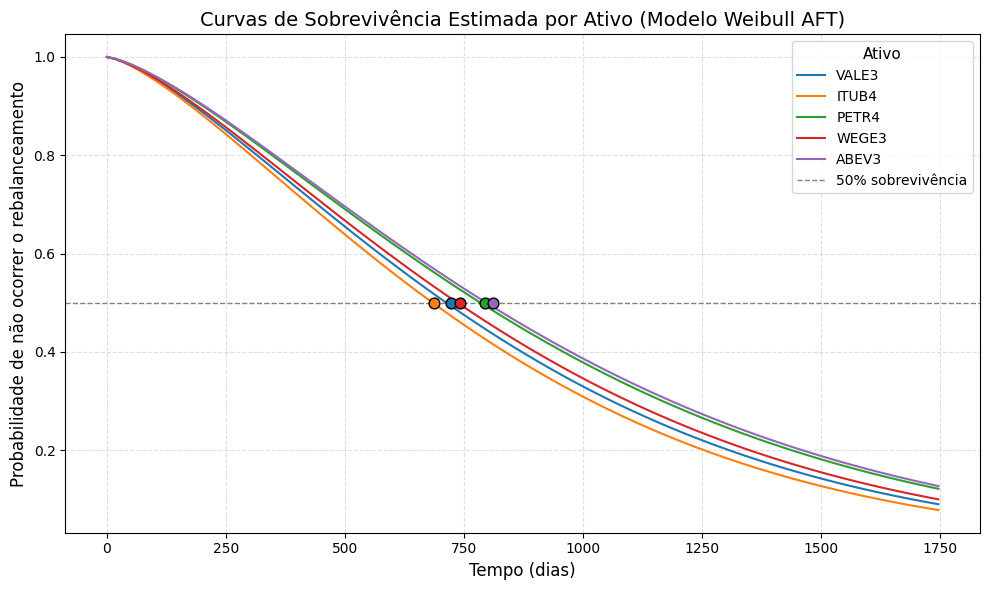

In [17]:
# -----------------------------------
# 3. PLOTAR CURVAS DE SOBREVIV√äNCIA
# ----------------------------------
# Cria figura e eixos
fig, ax = plt.subplots(figsize=(10, 6))

# Paleta de cores para distinguir os ativos
cores = sns.color_palette("tab10", n_colors=len(ativos))

# Plota curvas de sobreviv√™ncia por ativo
for i, ativo in enumerate(ativos):
    # Cria amostra com zeros e ativa a dummy correspondente (se existir)
    amostra = pd.DataFrame({col: [0] for col in df_model.columns if col not in ['Tempo', 'Evento']})

    # Ativa a dummy do ativo, se ela existir
    col_dummy = f'Ativo_{ativo}'
    if col_dummy in amostra.columns:
        amostra[col_dummy] = 1
    else:
        print(f"Aviso: Dummy {col_dummy} n√£o encontrada no modelo.")

    # Opcional: incluir frailty m√©dio (se existir)
    if 'Frailty' in amostra.columns:
        amostra['Frailty'] = df_model['Frailty'].mean()

    # Gera curva de sobreviv√™ncia
    tempos = np.linspace(0.1, df_eventos['Tempo'].max(), 100)
    surv_func = aft.predict_survival_function(amostra, times=tempos)

    # Plota curva
    ax.plot(surv_func.index, surv_func.values.flatten(),
            label=ativo, color=cores[i])

    # Mediana de sobreviv√™ncia (onde sobrevive = 0.5)
    y = surv_func.values.flatten()
    x = surv_func.index
    cruzamento = np.where(y <= 0.5)[0]
    if cruzamento.size > 0:
        tempo_mediano = x[cruzamento[0]]
        ax.scatter(tempo_mediano, 0.5, color=cores[i],
                   s=60, marker='o', edgecolor='black', zorder=5)
    else:
        print(f"A curva de {ativo} n√£o atinge 50% de sobreviv√™ncia no per√≠odo analisado.")

# Linha horizontal em 50%
ax.axhline(0.5, color='gray', linestyle='--', linewidth=1, label='50% sobreviv√™ncia')

# Labels
ax.set_title('Curvas de Sobreviv√™ncia Estimada por Ativo (Modelo Weibull AFT)', fontsize=14)
ax.set_xlabel('Tempo (dias)', fontsize=12)
ax.set_ylabel('Probabilidade de n√£o ocorrer o rebalanceamento', fontsize=12)

# Legenda
ax.legend(title="Ativo", fontsize=10, title_fontsize=11)

# Grid e est√©tica
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# **Pr√©-c√°lculos para a Etapa de Otimiza√ß√£o Bayesiana com Optuna**

Antes da execu√ß√£o da etapa de otimiza√ß√£o propriamente dita, foram realizados pr√©-c√°lculos essenciais para alimentar a fun√ß√£o objetivo utilizada na etapa 4, onde se aplica a otimiza√ß√£o bayesiana com o pacote Optuna. Essa prepara√ß√£o envolve o c√°lculo de m√©tricas fundamentais associadas ao desempenho dos ativos financeiros: retorno e risco.

Primeiramente, os retornos di√°rios dos ativos foram obtidos a partir do hist√≥rico de pre√ßos (precos_historicos), utilizando a fun√ß√£o pct_change() do pandas, que calcula a varia√ß√£o percentual entre dias consecutivos. A fun√ß√£o dropna() √© aplicada em seguida para eliminar a primeira linha resultante com valor nulo, consequ√™ncia do c√°lculo de diferen√ßa percentual.

In [18]:
# --------------------------------------------------------------------------
# PR√â-C√ÅLCULOS PARA A FUN√á√ÉO NA 4¬™ ETAPA DE OTIMIZA√á√ÉO BAYESIANA COM OPTUNA
# --------------------------------------------------------------------------

# Calcula retornos e riscos hist√≥ricos
retornos_diarios = precos_historicos.pct_change().dropna()
retornos_ativos = retornos_diarios.mean().to_dict()
riscos_ativos = retornos_diarios.std().to_dict()

# Pesos para combina√ß√£o de riscos
alpha = 0.7  # peso para risco hist√≥rico
beta = 0.3   # peso para risco estrutural (frailty)

# Mapear pre√ßos atuais dos ativos
precos_ativos = dict(zip(df_api['Ticker'], df_api['Pre√ßo Atual']))
ativos = list(precos_ativos.keys())

# Par√¢metros padr√£o para casos com dados faltantes
RISCO_PADRAO = 0.1
FRAILTY_PADRAO = 0.0

# Combina√ß√£o dos riscos: hist√≥rico + estrutural
riscos_ativos_combinados = {
    ativo: alpha * riscos_ativos.get(ativo, RISCO_PADRAO) +
           beta * abs(frailty_ativos.get(ativo, FRAILTY_PADRAO))  # frailty como risco estrutural (magnitude)
    for ativo in ativos
}

Nesse ponto tentamos responder √† seguinte pergunta:

***‚ÄúQual seria a melhor aloca√ß√£o percentual nos ativos para maximizar retorno, minimizar risco e evitar rebalanceamentos caros?‚Äù***

Este trecho de c√≥digo realiza a otimiza√ß√£o dos pesos dos ativos da carteira utilizando a t√©cnica de Otimiza√ß√£o Bayesiana com a biblioteca Optuna. O objetivo principal √© encontrar a aloca√ß√£o ideal dos ativos ‚Äî ou seja, os percentuais que cada ativo deve representar na carteira ‚Äî de forma que o retorno esperado seja maximizado, enquanto o risco total e os custos de rebalanceamento sejam minimizados.

Primeiramente, s√£o calculados os retornos e riscos reais de cada ativo com base nos pre√ßos hist√≥ricos: o retorno √© obtido pela m√©dia dos retornos di√°rios e o risco pelo desvio padr√£o desses retornos. Tamb√©m √© utilizado o tempo mediano de perman√™ncia de cada ativo na carteira (calculado anteriormente) como uma forma de penalizar ativos que exigem rebalanceamento muito frequente.

A fun√ß√£o objetivo da otimiza√ß√£o recebe os pesos sugeridos para os ativos, normaliza esses pesos, e ent√£o calcula:

* o retorno esperado da carteira (m√©dia ponderada dos retornos),

* o risco total da carteira (m√©dia ponderada dos desvios padr√£o),

* e um custo de rebalanceamento proporcional √† frequ√™ncia com que os ativos s√£o comprados ou vendidos.

Esses tr√™s fatores s√£o combinados em uma m√©trica √∫nica chamada "score", que √© o valor a ser minimizado durante o processo de otimiza√ß√£o. Ao final, o Optuna retorna a melhor combina√ß√£o de pesos encontrada, representando a composi√ß√£o √≥tima da carteira segundo os crit√©rios definidos.

In [19]:
# -----------------------------------
# 4. OTIMIZA√á√ÉO BAYESIANA COM OPTUNA COM RESTRI√á√ÉO DE APORTES
# -----------------------------------

def funcao_objetivo(trial):
    peso_ativos = np.array([trial.suggest_float(f"peso_{i}", 0.0, 1.0) for i in range(len(ativos))])
    peso_soma = peso_ativos.sum()
    if peso_soma == 0:
        return float('inf')
    peso_ativos /= peso_soma  # Normaliza os pesos

    valor_alocado = peso_ativos * VALOR_APORTE

    quantidades = []
    for i, ativo in enumerate(ativos):
        preco = precos_ativos.get(ativo)
        if preco is None:
            raise ValueError(f"Pre√ßo n√£o encontrado para o ativo {ativo}")
        qtd = np.floor(valor_alocado[i] / preco)
        quantidades.append(qtd)

    quantidades = np.array(quantidades)

    if quantidades.sum() == 0:
        return float('inf')

    valor_utilizado = np.sum(quantidades * np.array([precos_ativos[ativo] for ativo in ativos]))
    if valor_utilizado > VALOR_APORTE:
        return float('inf')

    pesos_efetivos = (quantidades * np.array([precos_ativos[ativo] for ativo in ativos])) / valor_utilizado

    retornos = np.array([retornos_ativos.get(ativo, 0.0) for ativo in ativos])
    riscos = np.array([riscos_ativos_combinados.get(ativo, 0.1) for ativo in ativos])

    retorno_esperado = np.dot(pesos_efetivos, retornos)
    risco_total = np.dot(pesos_efetivos, riscos)

    # Objetivo: maximizar retorno e minimizar risco (via score = retorno - risco)
    return -(retorno_esperado - risco_total)


# Execu√ß√£o do estudo com Optuna

study = optuna.create_study(direction="minimize")
study.optimize(funcao_objetivo, n_trials=300)

# Impress√£o dos melhores resultados

print("\nMelhores aloca√ß√µes considerando o aporte:")

peso_ativos = np.array([study.best_params.get(f"peso_{i}", 0.0) for i in range(len(ativos))])
peso_ativos /= peso_ativos.sum()
valor_alocado = peso_ativos * VALOR_APORTE

quantidades = np.floor(valor_alocado / np.array([precos_ativos[ativo] for ativo in ativos]))
valor_total_utilizado = 0

pesos_efetivos = []

for i, ativo in enumerate(ativos):
    preco = precos_ativos.get(ativo)
    quantidade = quantidades[i]
    if quantidade > 0:
        valor_ativo = quantidade * preco
        valor_total_utilizado += valor_ativo
        pesos_efetivos.append(valor_ativo)
        print(f"{ativo}: {int(quantidade)} a√ß√µes (Pre√ßo: {preco:.2f}, Valor: {valor_ativo:.2f})")
    else:
        pesos_efetivos.append(0)

pesos_efetivos = np.array(pesos_efetivos) / valor_total_utilizado

print(f"\nValor total utilizado do aporte: R$ {valor_total_utilizado:.2f} de R$ {VALOR_APORTE:.2f}")

retorno_final = np.dot(pesos_efetivos, np.array([retornos_ativos[ativo] for ativo in ativos]))
risco_final = np.dot(pesos_efetivos, np.array([riscos_ativos_combinados[ativo] for ativo in ativos]))

print(f"\nRetorno esperado: {retorno_final:.4f}")
print(f"Risco total: {risco_final:.4f}")

if valor_total_utilizado > VALOR_APORTE:
    print("\n‚ö†Ô∏è Aten√ß√£o: O valor total utilizado ultrapassa o aporte! Corrija a fun√ß√£o de aloca√ß√£o.")
else:
    print("\n‚úÖ A aloca√ß√£o est√° dentro do valor do aporte.")

[I 2025-06-28 19:41:05,620] A new study created in memory with name: no-name-dc5c9f2d-6a17-4ec0-8748-43d4969ac2c1
[I 2025-06-28 19:41:05,634] Trial 0 finished with value: 0.21352381895221734 and parameters: {'peso_0': 0.11361963662228003, 'peso_1': 0.03892691921023672, 'peso_2': 0.7022256110270505, 'peso_3': 0.4993769964682835, 'peso_4': 0.17952360577404058}. Best is trial 0 with value: 0.21352381895221734.
[I 2025-06-28 19:41:05,638] Trial 1 finished with value: 0.19804272237359788 and parameters: {'peso_0': 0.023100182516718748, 'peso_1': 0.5363560740476955, 'peso_2': 0.8219978544078749, 'peso_3': 0.5864847289510826, 'peso_4': 0.6883271062837794}. Best is trial 1 with value: 0.19804272237359788.
[I 2025-06-28 19:41:05,641] Trial 2 finished with value: 0.20323495974488356 and parameters: {'peso_0': 0.9177992694669577, 'peso_1': 0.454125510126547, 'peso_2': 0.05992709830208198, 'peso_3': 0.33812914849379316, 'peso_4': 0.6069607053418626}. Best is trial 1 with value: 0.19804272237359788


Melhores aloca√ß√µes considerando o aporte:
VALE3: 3 a√ß√µes (Pre√ßo: 53.00, Valor: 159.00)
ITUB4: 3 a√ß√µes (Pre√ßo: 36.27, Valor: 108.81)
PETR4: 3 a√ß√µes (Pre√ßo: 31.21, Valor: 93.63)
ABEV3: 346 a√ß√µes (Pre√ßo: 13.15, Valor: 4549.90)

Valor total utilizado do aporte: R$ 4911.34 de R$ 5000.00

Retorno esperado: 0.0233
Risco total: 0.1764

‚úÖ A aloca√ß√£o est√° dentro do valor do aporte.


In [20]:
# Converte os dicion√°rios para arrays na mesma ordem de 'ativos'
retorno_ativos_array = np.array([retornos_ativos[ativo] for ativo in ativos])

risco_ativos_array = np.array([riscos_ativos.get(ativo, 0.1) for ativo in ativos])

rebal_freq_array = np.array([
    1 / tempo if tempo != 0 else 0
    for tempo in [tempos_por_ticker.get(ativo, 1) for ativo in ativos]
])# frequ√™ncia ‚âà 1 / tempo mediano

# **Otimiza√ß√£o Multiobjetivo com NSGA-II e MOPSO (via PyMoo)**

Nesta etapa do trabalho, foi implementado um modelo de otimiza√ß√£o multiobjetivo com o uso do pacote pymoo, visando a constru√ß√£o de carteiras de investimento eficientes sob m√∫ltiplos crit√©rios simult√¢neos. O modelo considera tr√™s objetivos principais: maximizar o retorno esperado, minimizar o risco (medido pelo desvio padr√£o dos retornos) e minimizar o custo de rebalanceamento da carteira. Para isso, foi definida uma classe personalizada (CarteiraMultiObjetivo) que representa formalmente o problema de otimiza√ß√£o a ser resolvido por algoritmos evolutivos como NSGA-II e MOPSO.

Cada carteira √© representada por um vetor de pesos, em que cada valor corresponde √† propor√ß√£o de capital alocada em um ativo. A fun√ß√£o de avalia√ß√£o calcula o retorno como o somat√≥rio ponderado dos retornos m√©dios dos ativos, o risco como a soma ponderada das volatilidades individuais e o custo de rebalanceamento como uma penalidade proporcional √† frequ√™ncia com que os ativos s√£o ajustados na carteira. Como o pymoo realiza minimiza√ß√µes por padr√£o, o retorno √© invertido (multiplicado por -1) para que seu valor m√°ximo represente a melhor solu√ß√£o. Al√©m disso, √© imposta uma restri√ß√£o que obriga a soma dos pesos a ser igual a 1, garantindo que 100% do capital esteja alocado.

Essa modelagem permite explorar a fronteira de Pareto, onde nenhuma solu√ß√£o √© superior a outra em todos os crit√©rios ao mesmo tempo. Assim, o investidor pode tomar decis√µes mais informadas com base em seu perfil de risco e prefer√™ncias em rela√ß√£o a custo e retorno.





In [21]:
# -----------------------------
# 5. OTIMIZA√á√ÉO MULTIOBJETIVO COM NSGA-II
# -----------------------------

# Define o problema de otimiza√ß√£o multiobjetivo
class CarteiraMultiObjetivo(Problem):
    def __init__(self):
        super().__init__(
            n_var=len(ativos),   # n√∫mero de ativos
            n_obj=3,             # retorno, risco e custo
            n_constr=1,          # soma dos pesos = 1
            xl=0.0,              # limite inferior dos pesos
            xu=1.0               # limite superior dos pesos
        )

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array(x)

        # Calcula os 3 objetivos
        retorno = np.dot(x, retorno_ativos_array)
        risco = np.dot(x, risco_ativos_array)
        custo = np.dot(x, rebal_freq_array) * 0.01  # penalidade por frequ√™ncia de rebalanceamento

        # Define objetivos (lembrando: pymoo minimiza ‚Üí -retorno para maximizar)
        out["F"] = np.column_stack([-retorno, risco, custo])

        # Restri√ß√£o: soma dos pesos deve ser 1
        out["G"] = np.sum(x, axis=1) - 1

# Instancia o problema
problem = CarteiraMultiObjetivo()

In [22]:
# Parametros de numero de gera√ß√µes comuns a todos os algoritmos
n_geracoes = 100
termination = get_termination("n_gen", n_geracoes)

Nesta etapa, foi configurado e executado o algoritmo evolutivo NSGA-II (Non-dominated Sorting Genetic Algorithm II), amplamente utilizado em problemas de otimiza√ß√£o multiobjetivo. A configura√ß√£o do algoritmo foi feita utilizando os componentes dispon√≠veis na biblioteca pymoo, com par√¢metros ajustados para balancear diversidade e converg√™ncia na busca por solu√ß√µes eficientes.

A popula√ß√£o inicial foi definida com 100 indiv√≠duos (pop_size=100), e a amostragem inicial dos pesos das carteiras foi feita de forma aleat√≥ria cont√≠nua com FloatRandomSampling. Para promover a recombina√ß√£o entre indiv√≠duos, foi utilizado o operador de crossover SBX (Simulated Binary Crossover) com probabilidade de 90% e par√¢metro de distribui√ß√£o Œ∑ = 15. Al√©m disso, foi aplicado o operador de muta√ß√£o polinomial (Polynomial Mutation - PM) com Œ∑ = 20, promovendo varia√ß√µes nos indiv√≠duos para evitar estagna√ß√£o prematura. A op√ß√£o eliminate_duplicates=True garante diversidade populacional ao eliminar solu√ß√µes repetidas.

Com o algoritmo configurado, a otimiza√ß√£o foi executada por meio da fun√ß√£o minimize, que recebe como par√¢metros o problema previamente definido (classe CarteiraMultiObjetivo), o algoritmo NSGA-II, os crit√©rios de termina√ß√£o (termination), uma semente aleat√≥ria fixa (seed=1) para garantir reprodutibilidade dos resultados, e a op√ß√£o save_history=True para armazenar a evolu√ß√£o das solu√ß√µes ao longo das gera√ß√µes. A flag verbose=False foi definida para evitar a exibi√ß√£o cont√≠nua de logs durante a execu√ß√£o.

Essa configura√ß√£o permitiu a explora√ß√£o eficiente do espa√ßo de solu√ß√µes, resultando em um conjunto de carteiras n√£o-dominadas que comp√µem a fronteira de Pareto, possibilitando ao investidor escolher entre diferentes trade-offs entre retorno, risco e custo.

In [23]:
# -----------------------------
# Configurar algoritmo NSGA-II
# -----------------------------
algorithm_nsga2 = NSGA2(
    pop_size=100,                               # tamanho da popula√ß√£o
    sampling=FloatRandomSampling(),             # amostragem inicial aleat√≥ria cont√≠nua
    crossover=SBX(prob=0.9, eta=15),            # operador de crossover Simulated Binary
    mutation=PM(eta=20),                        # operador de muta√ß√£o polinomial
    eliminate_duplicates=True                   # evita duplicatas na popula√ß√£o
)

# -----------------------------
# Executar otimiza√ß√£o
# -----------------------------
res_nsga2 = minimize(
    problem,                                    # problema de otimiza√ß√£o definido
    algorithm_nsga2,                            # algoritmo NSGA-II
    termination,                                # crit√©rio de parada
    seed=1,                                     # para reprodutibilidade
    save_history=True,                          # salva hist√≥rico de gera√ß√µes
    verbose=False                               # suprime sa√≠da detalhada
)

**üìä Resumo do gr√°fico de converg√™ncia (Hypervolume)**

Nesta etapa final, foi realizada a avalia√ß√£o da qualidade das solu√ß√µes obtidas ao longo da execu√ß√£o do algoritmo NSGA-II por meio do c√°lculo do Indicador de Hipervolume (HV ‚Äì Hypervolume Indicator), al√©m da identifica√ß√£o da solu√ß√£o mais balanceada entre os objetivos considerados (retorno, risco e custo). Por fim, um gr√°fico foi gerado para ilustrar a evolu√ß√£o da qualidade da fronteira ao longo das gera√ß√µes.

Primeiramente, todas as frentes de Pareto geradas a cada gera√ß√£o foram empilhadas (all_F) para determinar um ponto de refer√™ncia 10% acima dos piores valores encontrados em cada objetivo. Esse ponto de refer√™ncia √© necess√°rio para o c√°lculo do hipervolume, que mede o volume do espa√ßo dominado pelas solu√ß√µes n√£o dominadas em rela√ß√£o a esse ponto.

Em seguida, para cada gera√ß√£o armazenada no hist√≥rico do algoritmo (res_nsga2.history), foi computado o hipervolume da popula√ß√£o daquela gera√ß√£o utilizando a fun√ß√£o HV da biblioteca pymoo. Isso resultou em uma lista de valores de HV (hv_values), que permite visualizar se houve converg√™ncia e melhora na qualidade das solu√ß√µes ao longo do tempo.

Al√©m disso, foi implementado um procedimento para encontrar a solu√ß√£o mais balanceada, isto √©, aquela que apresenta o menor somat√≥rio de rankings normalizados entre os tr√™s objetivos. Isso foi feito ordenando os valores de retorno, risco e custo separadamente, atribuindo ranks a cada solu√ß√£o e, posteriormente, somando esses ranks. A solu√ß√£o com a menor soma de ranks foi identificada como a mais equilibrada e seu √≠ndice dentro da fronteira final foi armazenado.

Para fins de interpreta√ß√£o visual, foi criado um gr√°fico com a curva de evolu√ß√£o do HV ao longo das gera√ß√µes. A gera√ß√£o em que surgiu a solu√ß√£o mais balanceada foi destacada com uma linha vertical vermelha e anotada com suas m√©tricas de desempenho (valores de retorno, risco e custo convertidos para porcentagens), facilitando a identifica√ß√£o de trade-offs entre os objetivos. Essa visualiza√ß√£o fornece uma ferramenta pr√°tica para analisar a efici√™ncia da otimiza√ß√£o e selecionar carteiras de investimento com base em m√∫ltiplos crit√©rios simult√¢neos.

/tmp/ipython-input-28-3706327249.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


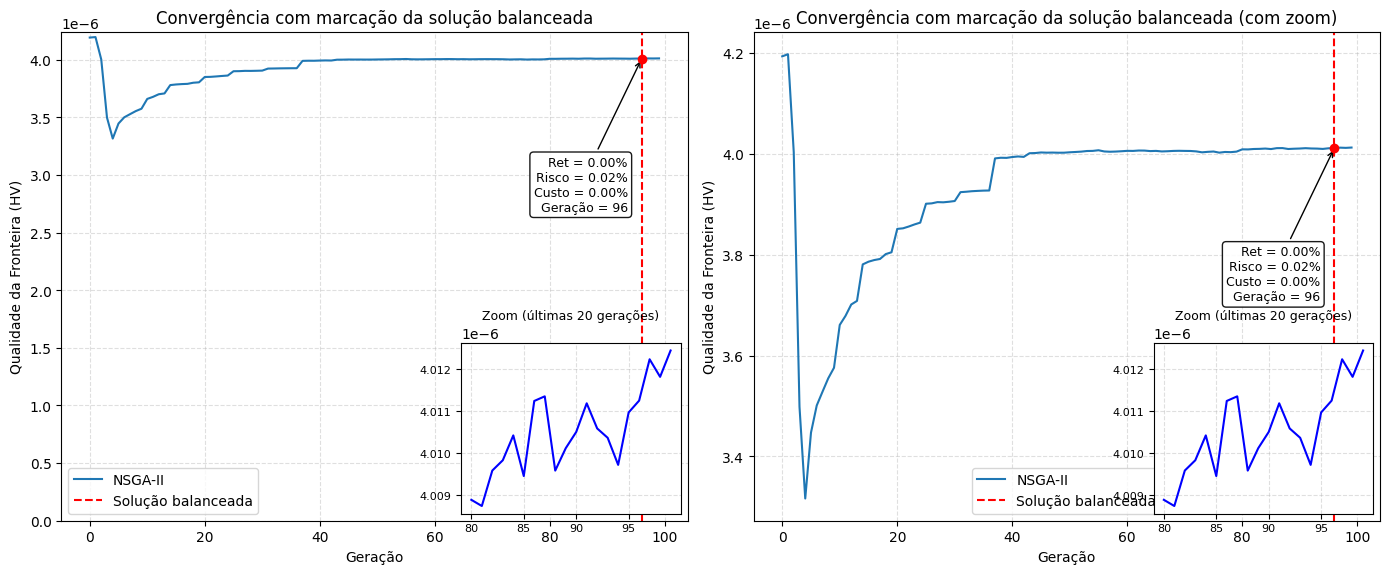

In [28]:
# -----------------------------
# Calcular HV por gera√ß√£o
# -----------------------------

all_F = np.vstack([gen.pop.get("F") for gen in res_nsga2.history])
ref_point = np.max(all_F, axis=0) * 1.1  # ponto de refer√™ncia 10% acima do pior valor em cada objetivo

hv = HV(ref_point=ref_point)
hv_values = [hv.do(gen.pop.get("F")) for gen in res_nsga2.history]

# -----------------------------
# Encontrar solu√ß√£o mais balanceada (m√≠nima soma de ranks)
# -----------------------------

pareto_objectives = res_nsga2.F  # [ -retorno, risco, custo ]

rankings = np.zeros_like(pareto_objectives)
for i in range(pareto_objectives.shape[1]):
    rankings[:, i] = np.argsort(np.argsort(pareto_objectives[:, i]))

rank_sums = np.sum(rankings, axis=1)
melhor_idx = np.argmin(rank_sums)
melhor_obj = pareto_objectives[melhor_idx]

# Localizar em qual gera√ß√£o essa solu√ß√£o apareceu
geracao_melhor_balanceada = None
for gen_idx, gen in enumerate(res_nsga2.history):
    F_gen = gen.pop.get("F")
    for f in F_gen:
        if np.allclose(f, melhor_obj, rtol=1e-5, atol=1e-8):
            geracao_melhor_balanceada = gen_idx
            break
    if geracao_melhor_balanceada is not None:
        break

# -----------------------------
# Fun√ß√£o reutiliz√°vel para plotar
# -----------------------------

def plot_hv(ax, hv_values, title, show_annotation=False, ylim_zero=False):
    ax.plot(np.arange(len(hv_values)), hv_values, label='NSGA-II')

    if ylim_zero:
        ax.set_ylim(bottom=0)

    if show_annotation and geracao_melhor_balanceada is not None:
        # Linha vertical da solu√ß√£o balanceada
        ax.axvline(x=geracao_melhor_balanceada, color='red', linestyle='--', label='Solu√ß√£o balanceada')
        ax.scatter(geracao_melhor_balanceada, hv_values[geracao_melhor_balanceada], color='red', zorder=5)

        # Texto de anota√ß√£o
        x_text = ax.get_xlim()[1] - 10
        y_text = ax.get_ylim()[1] * 0.95

        ax.annotate(
            f'Ret = {-melhor_obj[0]*100:.2f}%\nRisco = {melhor_obj[1]*100:.2f}%\nCusto = {melhor_obj[2]*100:.2f}%\nGera√ß√£o = {geracao_melhor_balanceada}',
            xy=(geracao_melhor_balanceada, hv_values[geracao_melhor_balanceada]),
            xytext=(-10, -70),  # mais √† direita (x) e mais abaixo (y)
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'),
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9),
            ha='right',  # alinha √† direita da caixa de texto
            va='top'     # alinha o topo da caixa com o ponto de origem
        )

        # Inserir gr√°fico de zoom no canto inferior direito
        ax_inset = inset_axes(ax, width="35%", height="35%", loc="lower right")
        zoom_start = max(0, len(hv_values) - 20)
        zoom_end = len(hv_values)
        ax_inset.plot(np.arange(zoom_start, zoom_end), hv_values[zoom_start:zoom_end], color='blue')
        ax_inset.set_title("Zoom (√∫ltimas 20 gera√ß√µes)", fontsize=9)
        ax_inset.grid(True, linestyle='--', alpha=0.4)
        ax_inset.tick_params(labelsize=8)

    ax.set_title(title)
    ax.set_xlabel("Gera√ß√£o")
    ax.set_ylabel("Qualidade da Fronteira (HV)")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend()

# -----------------------------
# Criar gr√°fico com subplots lado a lado
# -----------------------------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gr√°fico com anota√ß√£o e zoom
plot_hv(ax1, hv_values, "Converg√™ncia com marca√ß√£o da solu√ß√£o balanceada", show_annotation=True, ylim_zero=True)

# Gr√°fico com y iniciando em zero
plot_hv(ax2, hv_values, "Converg√™ncia com marca√ß√£o da solu√ß√£o balanceada (com zoom)", show_annotation=True, ylim_zero=False)

plt.tight_layout()
plt.show()

Nesta etapa final do processo, foi realizado o plot da fronteira de Pareto em tr√™s dimens√µes para comparar visualmente os resultados obtidos pelos tr√™s algoritmos utilizados: NSGA-II, NSGA-III e R-NSGA-II. Cada subgr√°fico apresenta uma nuvem de pontos representando as solu√ß√µes n√£o-dominadas encontradas por cada algoritmo no espa√ßo dos tr√™s objetivos: retorno, risco e custo.

Como o retorno foi modelado para ser minimizado durante o processo de otimiza√ß√£o (ou seja, convertido em negativo), ele foi invertido no momento da visualiza√ß√£o (-res.F[:, 0]) para que os gr√°ficos reflitam corretamente a l√≥gica intuitiva de que maior retorno √© melhor.

Esse tipo de visualiza√ß√£o √© essencial para comparar a distribui√ß√£o e a qualidade das solu√ß√µes encontradas, identificando por exemplo quais algoritmos tendem a explorar melhor certas regi√µes da fronteira de Pareto, ou quais apresentam maior diversidade e cobertura em rela√ß√£o aos objetivos.

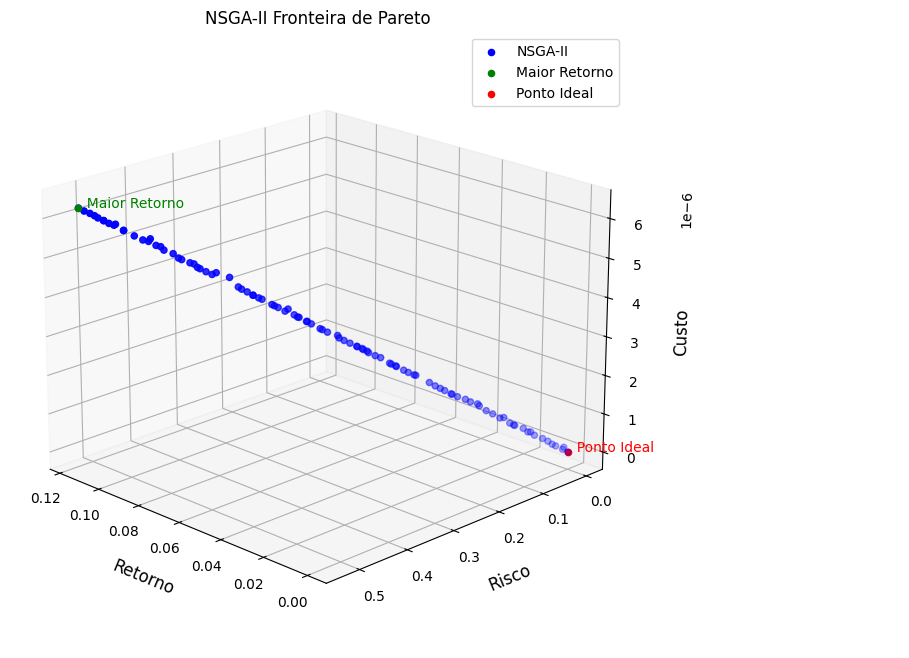

In [90]:
# -----------------------------
# 6. PLOTAR FRONTEIRA DE PARETO
# -----------------------------

def marcar_pontos(ax, F):
    retorno = -F[:, 0]  # Inverte para maximizar
    risco = F[:, 1]
    custo = F[:, 2]

    # Ponto com maior retorno
    idx_max_ret = np.argmax(retorno)
    ponto_max_ret = (retorno[idx_max_ret], risco[idx_max_ret], custo[idx_max_ret])
    ax.scatter(*ponto_max_ret, c='green', s=80, marker='.', label='Maior Retorno')
    ax.text(*ponto_max_ret, '  Maior Retorno', color='green')

    # Ponto ideal: maior retorno, menor risco e menor custo
    idx_ideal = np.argmax(retorno - risco - custo)
    ponto_ideal = (retorno[idx_ideal], risco[idx_ideal], custo[idx_ideal])
    ax.scatter(*ponto_ideal, c='red', s=80, marker='.', label='Ponto Ideal')
    ax.text(*ponto_ideal, '  Ponto Ideal', color='red')

# -----------------------------
# 6. PLOTAR FRONTEIRA DE PARETO
# -----------------------------
fig = plt.figure(figsize=(15, 8))

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])

# NSGA-II
ax1 = fig.add_subplot(111, projection='3d')
retorno_nsga2 = -res_nsga2.F[:, 0]
ax1.scatter(retorno_nsga2, res_nsga2.F[:, 1], res_nsga2.F[:, 2], c='blue', label='NSGA-II')
ax1.set_title('NSGA-II Fronteira de Pareto')
ax1.set_xlabel('Retorno', fontsize=12, labelpad=10)
ax1.set_ylabel('Risco', fontsize=12, labelpad=10)
ax1.set_zlabel('Custo', fontsize=12, labelpad=10)

ax2 = fig.add_subplot(gs[1])  # subplot vazio
ax2.axis('off')

ax1.view_init(elev=20, azim=135)
marcar_pontos(ax1, res_nsga2.F)
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend()
plt.show()

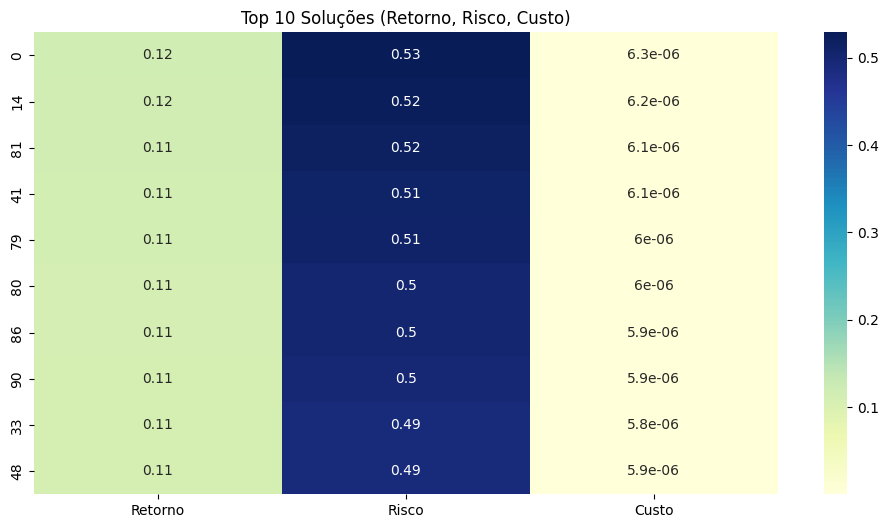

In [100]:
dados = pd.DataFrame({
    'Retorno': -res_nsga2.F[:, 0],
    'Risco': res_nsga2.F[:, 1],
    'Custo': res_nsga2.F[:, 2]
})

plt.figure(figsize=(12, 6))
sns.heatmap(dados.sort_values(by='Retorno', ascending=False).head(10), annot=True, cmap='YlGnBu')
plt.title('Top 10 Solu√ß√µes (Retorno, Risco, Custo)')
plt.show()
